In [20]:
from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

from functools import partial
import numpy as np

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

In [35]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target
y = (y > 1)*1   # to convert problem from multiclass- to 2-class classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


### Short tutorial

**fmin** - central function of hyperopt, it performs guided search for a function minimum. It returns the point from parameters hyperspace that yielded the lowest loss. Most important arguments are:
    - fn - function to minimize. Must accept a sample from parameters hyperspace and return real number (~scorer for GridSearchCV);
    - space - parameters hyperspace to sample from;
    - algo - algorithm which suggests new point given the points history. There are two options - tpe.suggest (guided search) and tpe.rand.suggest   
             (essentially random search);
    - max_evals - max number of points to sample;
    - trials - object of class Trial to keep track of optimization history;
    - rstate - pseudo-random generator seed, analogous to random_state from sklearn, for reproducibility;
    - show_progressbar - well, kind of explains itself, doesn't it?
**hp** - submodule to construct parameters hyperspace;  
**tpe** - submodule, which component tpe.suggest is the heart on hyperopt. It is an algorithm for guided points sampling, named Tree of Parzen Estimators;  
**Trials** - class, instances of which keep track of entire optimization process (stuff like parameters values, loss values, etc.);  
**space_eval** (optional) - sometimes useful for restoring parameters values from hyperspace in case of complex hyperspaces;    
**scope** - (optional) - submodule, among other things used for parameters type transformation. Say, you draw something from normal distribution,   
            which comes out as float,   but your model accepts only integer types - scope rushes for help;  
**sample** - (optional) - function to draw sample from hyperspace. Not required, but useful for testing whether you described your 
             hyperspace correctly before running fmin.  

### Step 1: hyperparameter space to sample from

In [ ]:
ho_scope.logi

In [69]:
hp_space = {
    # for StandardScaler
    'scale': {'with_std': hp.choice('with_std', [True, False])},
    # for classifier (Random Forest)
    'clf': {
            'n_estimators': ho_scope.int(hp.uniform('n_estimators', low=10, high=200)),   # for int hyperparams
            'criterion': hp.choice('criterion', ['gini', 'entropy']),   # for cateforical hyperparam
            'max_features': hp.uniform('max_features', low=0.25, high= 1.0)   # for float hyperparam
            }
}

In [61]:
ho_sample(hp_space)

{'clf': {'criterion': 'gini',
  'max_features': 0.4269305373057428,
  'n_estimators': 64},
 'scale': {'with_std': True}}

### Step 2: function

Essentially, it is a machine learning model which depends on hyperparameters

In [62]:
def f_clf(hyper_params):
    """
    Constructs estimator
    
    Parameters:
    ----------------
    hyper_params : sample point from search space
    
    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """
    
    # Assembing pipeline
    model = Pipeline([
        ('scale', StandardScaler(**hyper_params['scale'], 
                                 with_mean = True)), 
        ('clf', RandomForestClassifier(**hyper_params['clf'], 
                                       max_depth = 30))
    ])
    
    return model

### Step 3: loss to minimise

In [63]:
def loss_to_min(hyper_params, X, y, cv=5):
    """
    Target function for optimization
    
    Parameters:
    ----------------
    hps : sample point from search space
    X : feature matrix
    y : target array
    ncv : number of folds for cross-validation
    
    Returns:
    ----------------
    : target function value (negative mean cross-val ROC-AUC score)
    """
    
    model = f_clf(hyper_params)
    cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(cv, random_state=42), 
                             scoring='roc_auc', n_jobs=-1)
    
    return -cv_res.mean()   # as we minimize this function (minimize -roc_auc)

### Step 4: Run optimization

**Note**: We are binding X and y arguments of target function to X_train and y_train respectively,   
using *functools.partial*, since target function of fmin may accept only a search space point.

In [70]:
trials_clf = Trials()   # keep track of optimization
best_clf = fmin(partial(loss_to_min, X=X_train, y=y_train), 
                 hp_space, 
                 algo=tpe.suggest, 
                 max_evals=20, 
                 trials=trials_clf, 
                 rstate=np.random.RandomState(42))

100%|██████████| 20/20 [00:04<00:00,  3.71it/s, best loss: -0.8918367346938775]


In [71]:
print('Best parameters:')
print(space_eval(hp_space, best_clf))

Best parameters:
{'clf': {'criterion': 'gini', 'max_features': 0.3757242297237475, 'n_estimators': 27}, 'scale': {'with_std': False}}


### Step 5: fitting model with the best hyperparameters

In [72]:
clf_best = f_clf(space_eval(hp_space, best_clf)).fit(X_train, y_train)

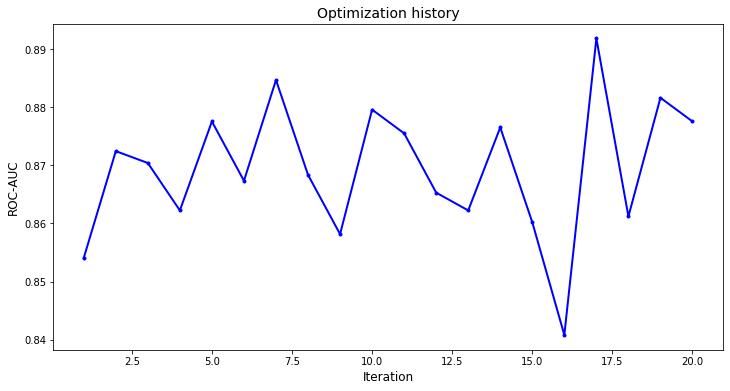

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))
ax.plot(range(1, len(trials_clf) + 1), [-x['result']['loss'] for x in trials_clf], 
        color='blue', marker='.', linewidth=2)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('Optimization history', fontsize=14)
plt.show()